In [1]:
import json
import os
import urllib
import sys

In [2]:
import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# For letting CUDA work with multiprocessing

Stages of Instruction fine-tuning:

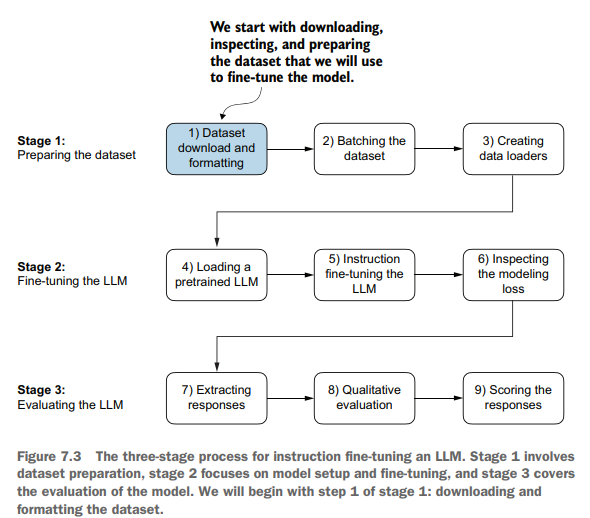

## Dataset downloading and formatting

In [3]:
l = os.path.join(os.getcwd(), '..')
print(l)
m = os.path.abspath(l)
print(m)

# Adds that absolute parent path to the Python module search path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

/home/mejan/projects/LLM/chap_7/..
/home/mejan/projects/LLM


In [4]:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    else: 
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

        with open(file_path, "r") as file:
            data = json.load(file)
    return data


cwd_path = os.getcwd()


parent_path = os.path.join(cwd_path, '..')


relative_file_path = os.path.join(parent_path, 'data', 'instruction-data.json') # This is still a relative path with .. in it.


file_path = os.path.abspath(relative_file_path) 
url = (
 "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
 "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [5]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [6]:
print("Another example entry:\n", data[999])
# Based on the contents of this entry, the 'input' field may occasionally be empty:

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### Prompt styles for instruction fine-tuning in LLM

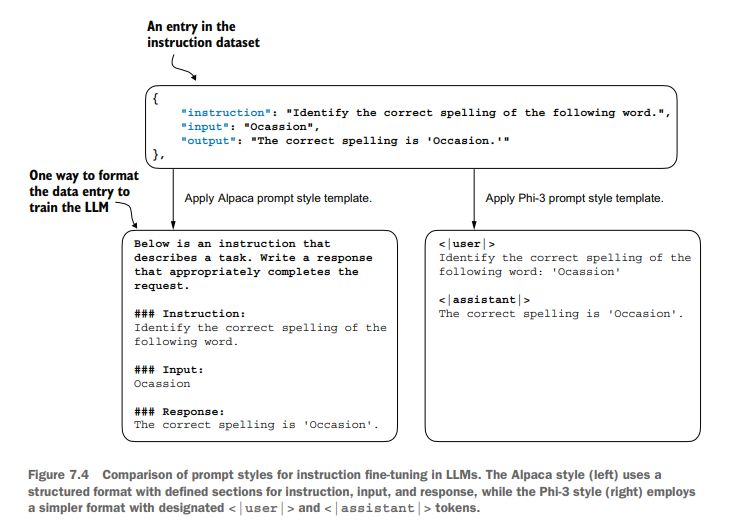

PH3 (e.g., OpenHermes-2.5-Mistral, Phind-CodeLLaMA) tends to outperform Alpaca in reasoning, coding, and real-world usage.

Alpaca is more of a research demo, with older, simpler data (Stanford’s self-instruct 52K).

In [7]:
# Formatting function for Alpaca style:

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text


In [8]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [9]:
# Skipping input if it is empty

model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


Partioning the dataset

In [10]:

train_portion = int(len(data) * 0.85) 
test_portion = int(len(data) * 0.1) 
val_portion = len(data) - train_portion - test_portion 

train_data = data[: train_portion]
test_data = data[train_portion: train_portion + test_portion]
val_data = data[train_portion + test_portion: ]


print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Batching the dataset

We need to convert the dataset into it's tokenized format keeping every sample in a batch of same length.

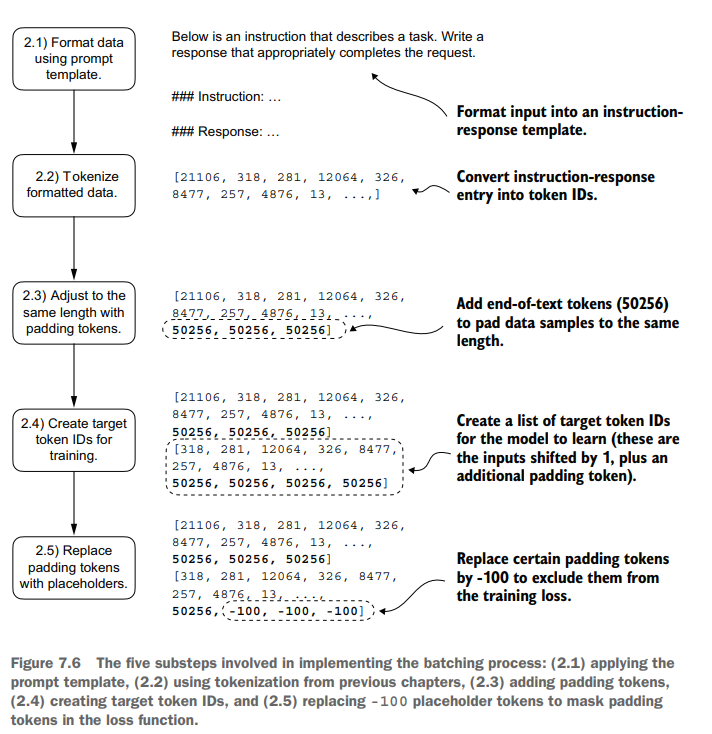

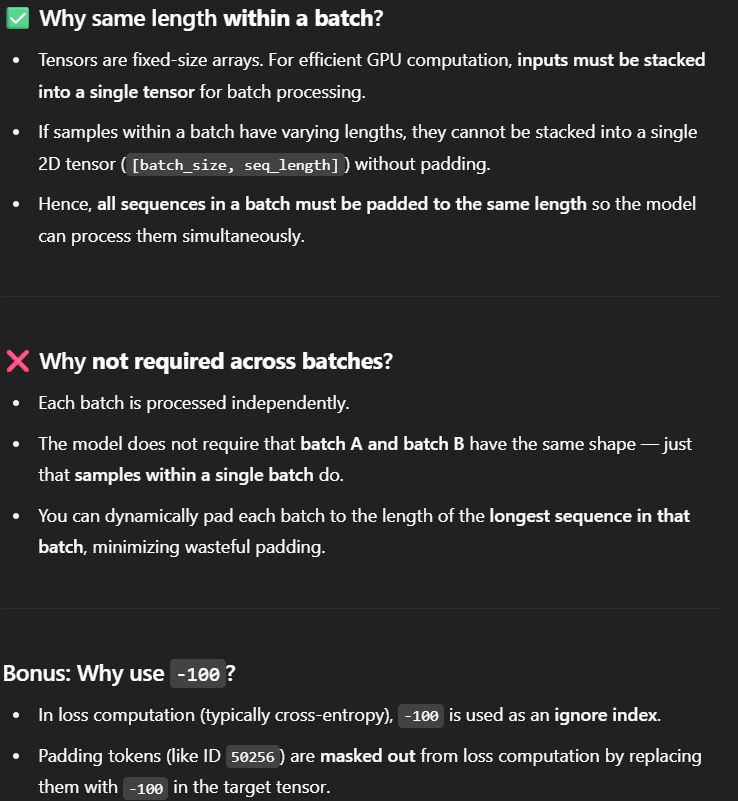

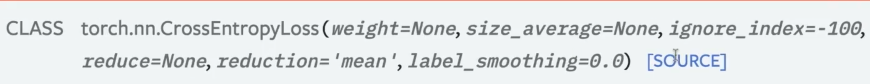

#### But Why Shift the Input for Fine-Tuning?

At first glance, it might seem that the target should only be the response

1. Consistency with Pre-Training Objective:

* GPT-2 is pre-trained using a **causal language modeling objective**, where it predicts the next token for every token in the sequence. The right-shifted target ensures the model learns the probability distribution $P(x_{t} | x_{<t})$ for all tokens in the sequence.

* During fine-tuning, maintaining the same objective (next-token prediction) ensures compatibility with the pre-trained weights. Changing the objective (e.g., only predicting the response) would require a different loss function or architecture, potentially disrupting the model’s learned representations.


2. Modeling the Entire Sequence

* The model is trained to predict every token in this sequence, not just the response. This approach ensures the model learns the structure of the prompt and the transition from prompt to response, which is critical for tasks like instruction tuning or dialogue systems.


### Implementing the first two steps

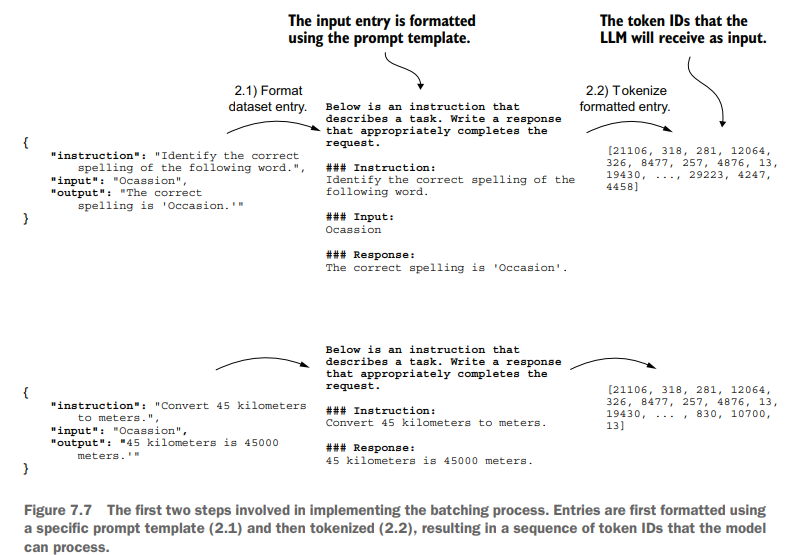

In [11]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [12]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):

        self.data = data
        self.encoded_texts = []
        
        for entry in data: 
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"

            
            full_text = instruction_plus_input + response_text # Alpaca-style formatting is complete

            # Tokenize the full input/output text 
            # and append each input/output pair to the list
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
 
    def __getitem__(self, index):
        return self.encoded_texts[index]
 
    def __len__(self):
        return len(self.data)

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


### Implementing Step 3 (Padding)

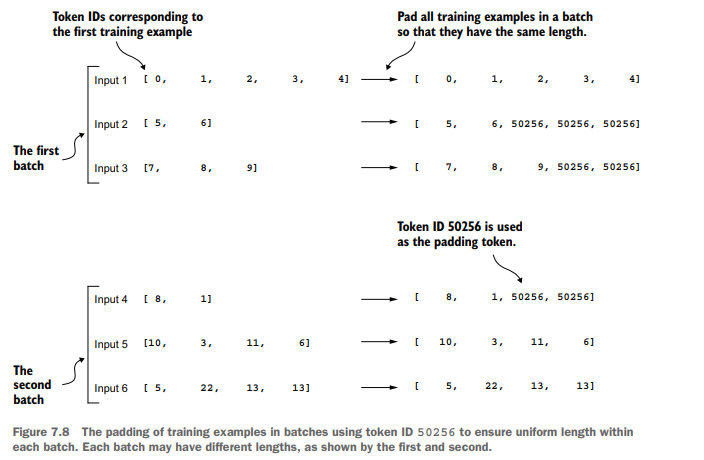

The default `collate_fn` in PyTorch (used when you don’t specify a custom one in the `DataLoader`) is designed to handle standard data types and aggregate samples into batches.

* Stacks individual samples into a batch.

* Assumes all tensors in the batch are the same shape (i.e., no padding is applied).

* Will raise an error if samples are different lengths (e.g., sequences of varying token lengths).

So, to perform padding in each batch and then create a batch, we need a `custom_collate_fn`

In [14]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):

    # Find the maximum length of the input sequences in the batch and add 1
    # +1 is needed when creating target in the second draft of this function
    batch_max_length = max(len(item)+1 for item in batch) 

    inputs_lst = []
    for item in batch: 

        new_item = item.copy()
        # Add an <|endoftext|> token to the end of each input sequence
        new_item += [pad_token_id]

        
        padded = (
        new_item + [pad_token_id] * 
        (batch_max_length - len(new_item))
        )
        # Removes extra padded token
        inputs = torch.tensor(padded[:-1]) 
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device) 
    
    return inputs_tensor

In [15]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
 inputs_1,
 inputs_2,
 inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


### Implementing Step 4 (Creating target token IDs)

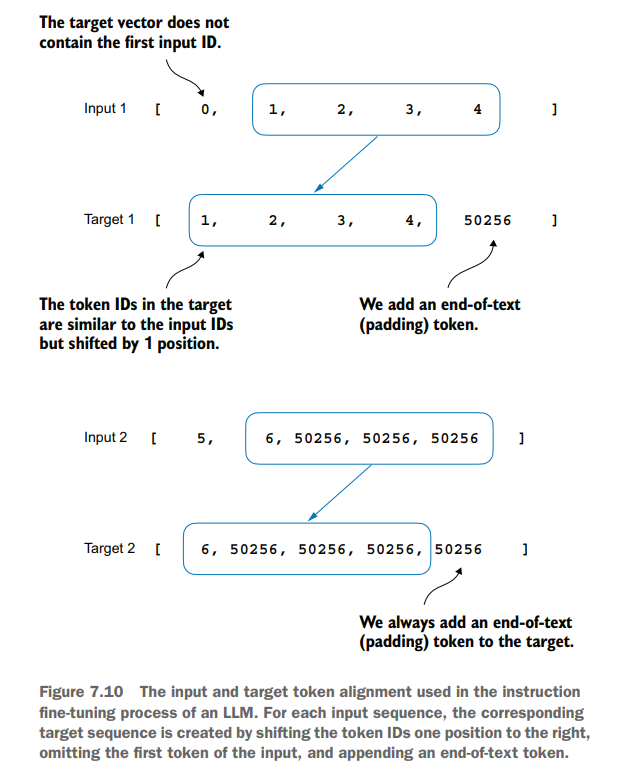

Because we already added an extra padding token in the `custom_collate_draft_1` function, the process is simpler

In [16]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):

    # The +1 is necessary because the function appends an extra token (the pad_token_id) 
    # to each sequence before padding and then constructs inputs and targets with a one-token shift.
    batch_max_length = max(len(item)+1 for item in batch) 

    inputs_lst, targets_lst = [], []
    for item in batch: 

        new_item = item.copy()

        new_item += [pad_token_id]

        
        padded = (
        new_item + [pad_token_id] * 
        (batch_max_length - len(new_item))
        )
        # Removes extra padded token
        # Truncates the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # Shifts +1 to the right for targets
        targets = torch.tensor(padded[1:])

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device) 
    
    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


### Implementing Step 5 (-100 placeholder)

This special value allows us to **exclude** these padding tokens from **contributing to the training loss calculation**, ensuring that only meaningful data influences model learning.

BUT, we retain one end-of-text token, ID $50256$, in the target list, as depicted in figure below: 

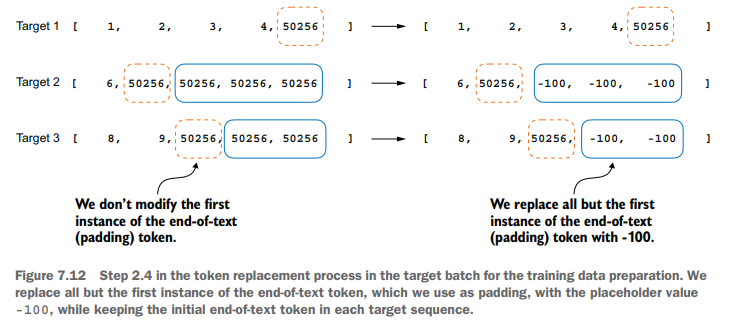

Retaining it allows the LLM to learn when to generate an endof-text token in response to instructions, which we use as an **indicator** that the **generated response is complete**.

In [18]:
## Simple demonstration of loss remaining same when we use -100

logits_1 = torch.tensor(
    [[-1.0, 1.0],  # Prediction for 1st token
    [-0.5, 1.5]]   # Prediction for 2nd token
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)


# As we would expect, adding an additional token ID affects the loss calculation:

logits_2 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5],
    [-0.5, 1.5]] 
)

targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)


#Now let's get to the interesting part and see what happens if 
# we replace the third target token ID with -100

targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)


tensor(1.1269)
tensor(0.7936)
tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [19]:
# Finally, completing the collate function with the -100 token ID:

def custom_collate_fn(batch, pad_token_id=50256, ignore_index = -100, 
                      allowed_max_length=None, device="cpu"):

    # The +1 is necessary because the function appends an extra token (the pad_token_id) 
    # to each sequence before padding and then constructs inputs and targets with a one-token shift.
    batch_max_length = max(len(item)+1 for item in batch) 

    inputs_lst, targets_lst = [], []

    for item in batch: 

        new_item = item.copy()

        new_item += [pad_token_id]

        
        padded = (
        new_item + [pad_token_id] * 
        (batch_max_length - len(new_item))
        )
        # Removes extra padded token
        # Truncates the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # Shifts +1 to the right for targets
        targets = torch.tensor(padded[1:])

        # Replace all but the first occurrence of the pad_token_id with ignore_index
        mask = targets == pad_token_id 
        indices = torch.nonzero(mask).squeeze() 

        if indices.numel() > 1: 
            targets[indices[1:]] = ignore_index 
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length] 
            targets = targets[:allowed_max_length] 

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device) 
    
    return inputs_tensor, targets_tensor

Example illustration of the masking process

In [20]:
targets = torch.tensor([0, 1, 2, 50256, 50256])
pad_token_id = 50256
mask = targets == pad_token_id 
print(mask)

indices = torch.nonzero(mask)
print(indices)

indices = torch.nonzero(mask).squeeze()
print(indices)

if indices.numel() > 1: 
    targets[indices[1:]] = -100

print(targets)

tensor([False, False, False,  True,  True])
tensor([[3],
        [4]])
tensor([3, 4])
tensor([    0,     1,     2, 50256,  -100])


In [21]:
inputs, targets = custom_collate_fn(batch)
print("Inputs\n",inputs)
print("Targets\n",targets)

Inputs
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In addition to masking out padding tokens, it is also common to **mask out the target token IDs that correspond to the instruction**, as illustrated in figure:

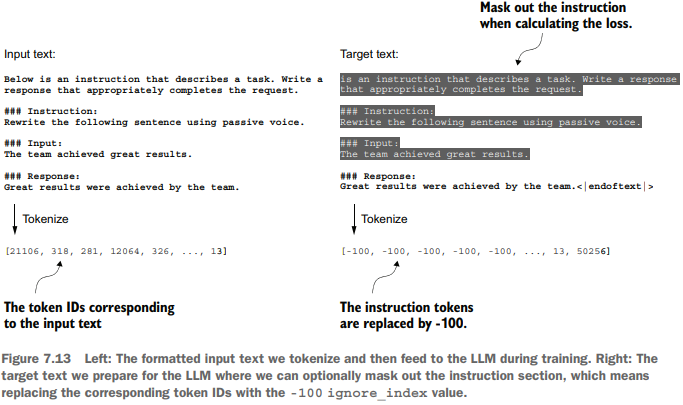

By masking out the LLM’s target token IDs corresponding to the instruction, the cross entropy loss is only computed for the generated response target IDs. Thus, the model
is trained to focus on generating accurate responses rather than memorizing instructions, which can help reduce overfitting.

This can be done later as an experimentation for this chapter.

## Creating data loader
We are ready to reap the fruits of our labor by simply plugging both `InstructionDataset` objects and the `custom_collate_fn` function into PyTorch data loaders.

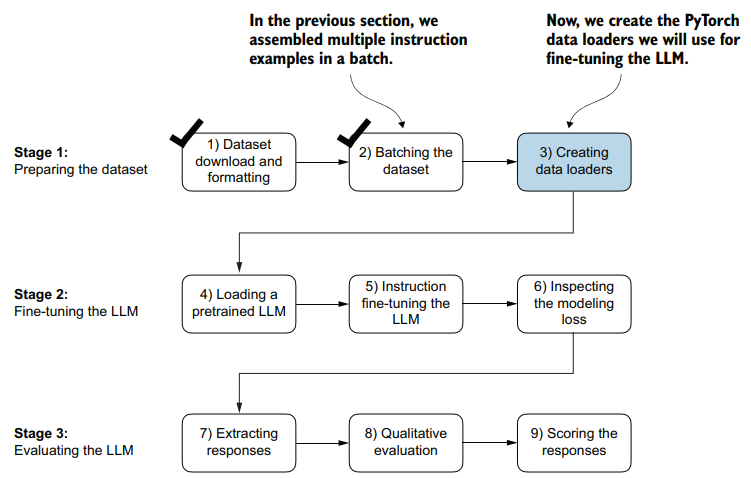

#### Why are we moving the data to device in collate ?

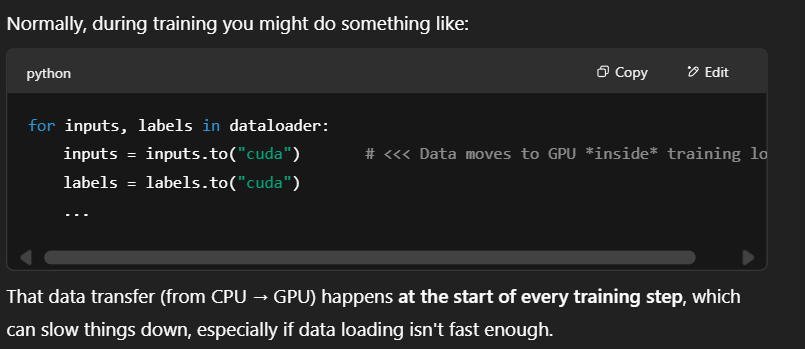

That data transfer (from CPU → GPU) happens at the start of every training step, which can slow things down, especially if data loading isn't fast enough.

We are ensuring:
* The batches are already on the GPU (or desired device) before the training step starts.

* This reduces training loop overhead — so the GPU doesn't sit idle waiting for data.

In essence, we're offloading this step to the data preparation stage, which can happen in parallel with other GPU work, especially if we use `num_workers` $> 0$ in our DataLoader.

Each worker:

* Fetches a sample from your Dataset

* Applies the collate_fn

* Returns a batch to the main process

So while the GPU is training on batch N, workers are already preparing batch N+1

Generally:

import multiprocessing

logical_cores = multiprocessing.cpu_count()

num_workers = min(logical_cores, logical_cores/2) # Or by 4

#### BUT there's a problem!

When we pass a `collate_fn` to PyTorch’s `DataLoader`, PyTorch expects just one argument: the batch (i.e., `collate_fn(batch)`).

But our `custom_collate_fn` takes more arguments: `device`, `pad_token_id`, `ignore_index`, `allowed_max_length`

Some arguments are default but some may change like: `device` and `allowed_max_length`

#### Solution: Use functools.partial

The `partial` function, from Python’s `functools` module, allows us to create a new function with some arguments of an existing function pre-filled. It “partially applies” the function by fixing certain arguments, leaving the remaining ones to be provided later.

In [22]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Actually using `num_workers` = anything other than 0 doesn't work with CUDA (doesn't like to be forked) and it's work-around with `multiprocessing` module's `spawn` doesn't work in jupyter cell. So, we are stuck with `num_workers = 0` for now.

We have to Move all dataset and collate_fn code into a separate .py module and import them.

In [25]:
num_workers = 0 
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [27]:
print("Train loader:")

inputs, targets = next(iter(train_loader))

print(inputs.shape, targets.shape)

inputs, targets = next(iter(train_loader))
print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 74]) torch.Size([8, 74])
